<a href="https://colab.research.google.com/github/aarandjel/importance-sampling-with-feedforward-networks/blob/main/arithmetic_asian_basket_call_multivariate_Black_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importance sampling for option pricing with feedforward networks

In this Jupyter notebook, we study the problem of reducing the standard error in Monte Carlo simulations when pricing path-dependent options through suitable changes of measure which are induced by feedforward networks.

We consider an arithmetic Asian basket call option in a multivariate Black-Scholes model.

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import norm
from tqdm.notebook import trange
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Concatenate, Subtract, Multiply, Lambda, Add, Dot
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Python version:  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Tensorflow version:  2.6.0
Keras version:  2.6.0


In [2]:
T = 1
N = 32
delta_t = T/N
strike = 70.0
r = 0.05
N_assets = 10
N_train = 3*10**5
learnrate = 0.001

In [6]:
X_0 = np.around(np.random.uniform(low=40.0, high=50.0, size=(N_assets,1)),0)
mu = np.around(np.random.uniform(low=0.0, high=0.10, size=(N_assets, 1)),2)
sigma = np.around(np.random.uniform(low=-0.3, high=0.3, size=(N_assets,N_assets)), 2)
volvec = (norm(sigma, axis=0) ** 2).reshape((N_assets,1))
tilde_mu = mu - 0.5 * volvec

weights = np.around(mu / (norm(sigma, axis=0)).reshape((N_assets,1)),2)
weights = weights / np.sum(weights)

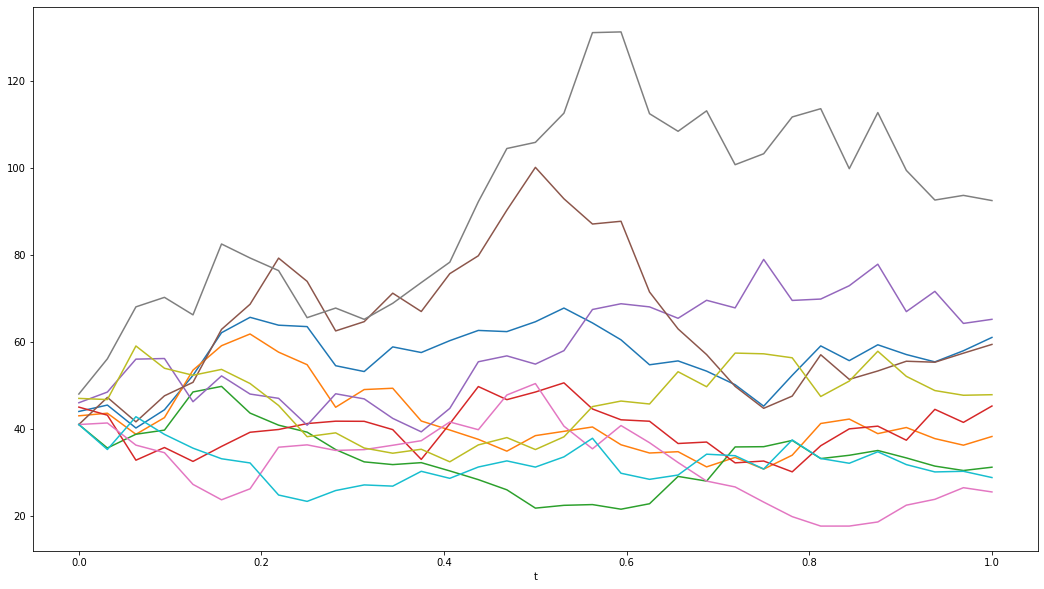

In [7]:
M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
M = np.cumsum(M, axis=1)
M = np.dot(np.transpose(sigma), M)
 
M = np.diff(M, axis=1)
M = M + tilde_mu * delta_t
 
M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
M = np.cumsum(M, axis=1)
 
M = np.exp(M)
for i in range(N_assets):
    M[i,:] = M[i,:] * X_0[i]
    
t = np.linspace(0, T, N+1) 
plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M))
plt.xlabel("t")
plt.show()

In [8]:
N_sample = 5000
outcomes = []
 
start_time = time.time()
 
for i in trange(N_sample):
    M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    M = np.cumsum(M, axis=1)
    M = np.dot(np.transpose(sigma), M)
 
    M = np.diff(M, axis=1)
    M = M + tilde_mu * delta_t
 
    M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
    M = np.cumsum(M, axis=1)
 
    M = np.exp(M)
    for j in range(N_assets):
        M[j,:] = M[j,:] * X_0[j]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)]
 
elapsed_time = time.time() - start_time
 
mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)
 
print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
 
print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

  0%|          | 0/5000 [00:00<?, ?it/s]

elapsed time:  00:00:01
Mean (MC):  3.3777
Standard error (MC):  0.931  ( 27.56 % )


In [9]:
def custom_activation(x):
    return 1.7159*K.tanh(2*x/3)

In [10]:
layers = []
 
layer = Dense(N_assets, activation=custom_activation, trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.2), 
              bias_initializer=initializers.RandomNormal(0.0, 0.2), 
              name=str(0))
 
layers = layers + [layer]
 
layer = Dense(N_assets, activation="linear", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.2), 
              bias_initializer=initializers.RandomNormal(0.0, 0.2), 
              name=str(1))
 
layers = layers + [layer]

In [11]:
xtrain = ([0*np.ones((N_train,1))] + # t_0
          [delta_t*np.ones((N_train,N_assets))] + # time increment
          [0*np.ones((N_train,N_assets))] + # M_0
          [np.tile(X_0.reshape((N_assets)), (N_train, 1))] + # X_0
          [np.tile(weights.reshape((N_assets))/T, (N_train, 1))] + # wght
          [0*np.ones((N_train,N_assets))] + # initial value of the payoff
          [0*np.ones((N_train,N_assets))] + # initial value of the first part of the stoch exp
          [0*np.ones((N_train,N_assets))] + # initial value of the second part of the stoch exp
          [np.random.normal(0,np.sqrt(delta_t),(N_train,N_assets)) for i in range(N)]) # Brownian increments
 
ytrain = np.zeros((N_train, 1))

In [12]:
t_0 = Input(shape=(1, ))
d_t = Input(shape=(N_assets, ))
 
M_0 = Input(shape=(N_assets, ))
X_start = Input(shape=(N_assets, ))
 
wght = Input(shape=(N_assets, ))
 
c_0 = Input(shape=(N_assets, ))
c_1 = Input(shape=(N_assets, ))
c_2 = Input(shape=(N_assets, ))
 
inputs = [t_0]+[d_t]+[M_0]+[X_start]+[wght]+[c_0]+[c_1]+[c_2]
 
t_current = t_0
M_current = M_0
X_current = X_start
 
for j in range(N):
    
    strategy = t_current
    strategy = layers[0](strategy)
    strategy = layers[1](strategy)
    
    incr_M = Input(shape=(N_assets, ))
    inputs = inputs + [incr_M]
    
    M_current = Add()([M_current, incr_M])
    helper_0 = tf.transpose(K.dot(K.constant(np.transpose(sigma)), tf.transpose(M_current)))
    helper_1 = Lambda(lambda x: tilde_mu.reshape((N_assets)) * x)(t_current)
    helper_2 = Add()([helper_1, helper_0])
    helper_3 = Lambda(lambda x: K.exp(x))(helper_2)
    helper_4 = Multiply()([helper_3, d_t])
    helper_5 = Multiply()([X_start, helper_4])
    helper_6 = Multiply()([wght, helper_5])
    c_0 = Add()([c_0, helper_6])
    
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    helper_e2 = Multiply()([strategy, strategy])
    helper_e3 = Multiply()([helper_e2, d_t])
    c_2 = Add()([c_2, helper_e3])
    
    t_current = Lambda(lambda x: x + delta_t)(t_current)
    
helper_e4 = Lambda(lambda x: -0.5 * K.sum(x, axis=1))(c_1)
helper_e5 = Lambda(lambda x: 0.25 * K.sum(x, axis=1))(c_2)
 
helper_e6 = Add()([helper_e4, helper_e5])
helper_e7 = Lambda(lambda x: K.exp(x))(helper_e6)
 
c_0 = Lambda(lambda x: K.sum(x, axis=1))(c_0)
c_0 = Lambda(lambda x: K.relu(x - strike))(c_0)
 
c_0 = Multiply()([c_0, helper_e7])
 
outputs = [c_0]

In [13]:
def custom_loss(y_true,y_pred):
    z = K.mean(K.square(y_pred))
    return z
 
adam = optimizers.Adam(learning_rate=learnrate)
 
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=adam,loss=custom_loss)

# model.summary()

In [19]:
# K.set_value(model.optimizer.learning_rate, 0.001)

In [14]:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights=True)

In [15]:
model.fit(x=xtrain, y=ytrain, epochs=25, verbose = 1, batch_size=100, validation_split=0.2, callbacks=[es])

Epoch 1/25
2400/2400 [==============================] - 68s 26ms/step - loss: 0.0265 - val_loss: 0.0145
Epoch 2/25
2400/2400 [==============================] - 58s 24ms/step - loss: 0.0099 - val_loss: 0.0087
Epoch 3/25
2400/2400 [==============================] - 58s 24ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 4/25
2400/2400 [==============================] - 58s 24ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 5/25
2400/2400 [==============================] - 58s 24ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 6/25
2400/2400 [==============================] - 58s 24ms/step - loss: 0.0048 - val_loss: 0.0072
Epoch 7/25
2400/2400 [==============================] - 58s 24ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 8/25
2400/2400 [==============================] - 57s 24ms/step - loss: 0.0048 - val_loss: 0.0074
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping


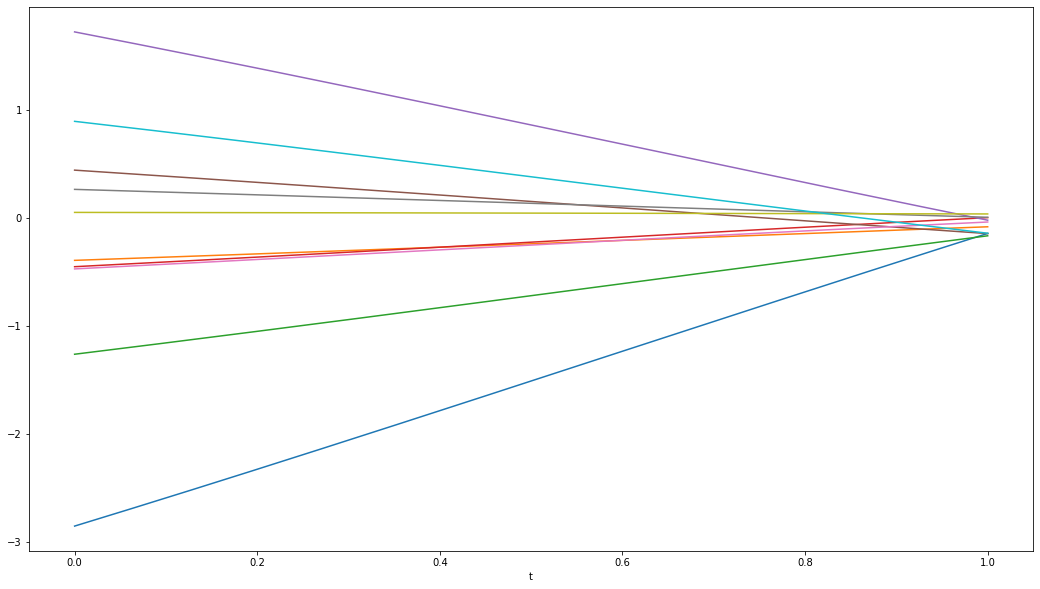

In [18]:
N = 252
delta_t = T/N
 
model_test = keras.Sequential()
model_test.add(Dense(N_assets, activation=custom_activation, name="layer1", input_shape=(1, )))
model_test.add(Dense(N_assets, activation="linear", name="layer2"))
 
model_test.build()
 
model_test.layers[0].set_weights(model.layers[27].get_weights())
model_test.layers[1].set_weights(model.layers[38].get_weights())
 
t = np.linspace(0, T, N+1)
learnedstrat = model_test.predict(t)
 
plt.figure(figsize=(18, 10))
plt.plot(t, learnedstrat)
plt.xlabel("t")
plt.show()

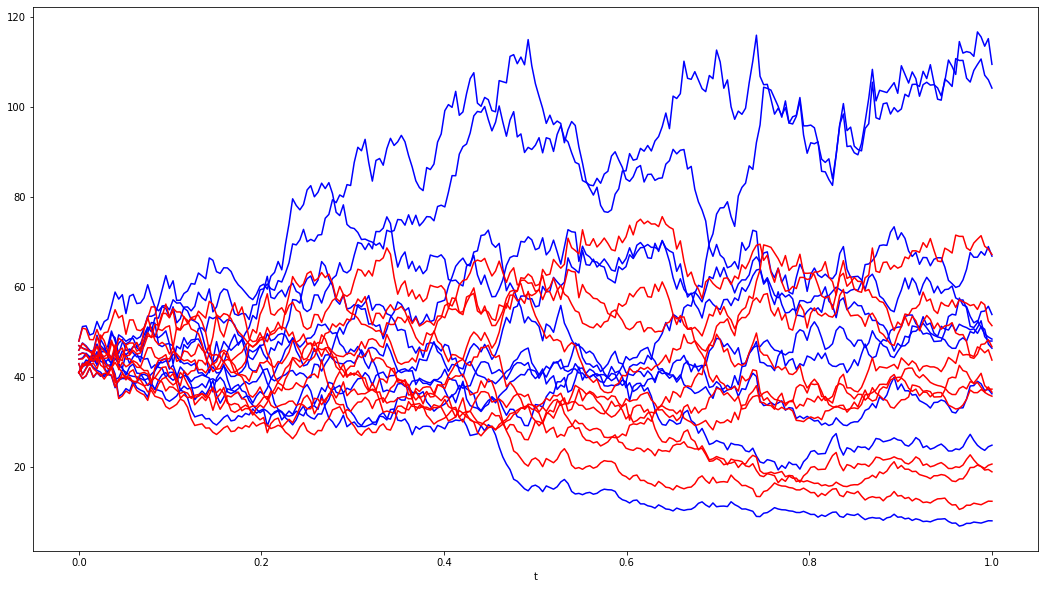

In [20]:
M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)

M_MC = np.cumsum(M_random, axis=1)
M_MC = np.dot(np.transpose(sigma), M_MC)

M_MC = np.diff(M_MC, axis=1)
M_MC = M_MC + tilde_mu * delta_t

M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
M_MC = np.cumsum(M_MC, axis=1)

M_MC = np.exp(M_MC)
for j in range(N_assets):
    M_MC[j,:] = M_MC[j,:] * X_0[j]
        
###

M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
M_0 = np.cumsum(M_0, axis=1)
M = np.dot(np.transpose(sigma), M_0)

M = np.diff(M, axis=1)
M = M + tilde_mu * delta_t

M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
M = np.cumsum(M, axis=1)

M = np.exp(M)
for j in range(N_assets):
    M[j,:] = M[j,:] * X_0[j]

plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M), color = "blue", label="with drift adjustment")
plt.plot(t, np.transpose(M_MC), color = "red", label="without drift adjustment")
plt.xlabel("t")
plt.show()

In [28]:
N_reps = 100
N_sample = 5000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
    outcomes_MC = []
    outcomes_IS = []
    
    for i in range(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/100 [00:00<?, ?it/s]

total elapsed time:  00:07:03


In [29]:
print("Mean (MC): ", np.around(np.mean(means_MC), 4))
print("Mean (IS): ", np.around(np.mean(means_IS), 4))
print("Average standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Average standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Average variance ratio: ", np.around(np.mean(varratio)))

Mean (MC):  2.0296
Mean (IS):  1.9227
Average standard error (MC):  0.5787  ( 28.51 % )
Average standard error (IS):  0.074  ( 3.85 % )
Average variance ratio:  75.0


mean MC estimate:   2.0296
mean IS estimate:  1.9227


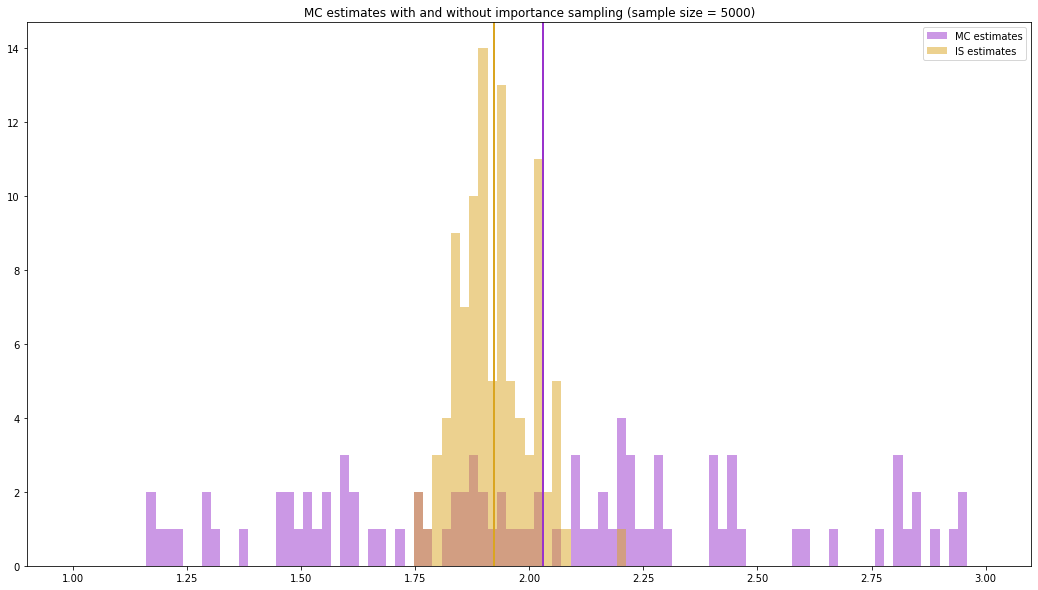

In [30]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(1.00, 3.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

mean MC estimate standard error:   0.5787
mean IS estimate standard error:  0.074


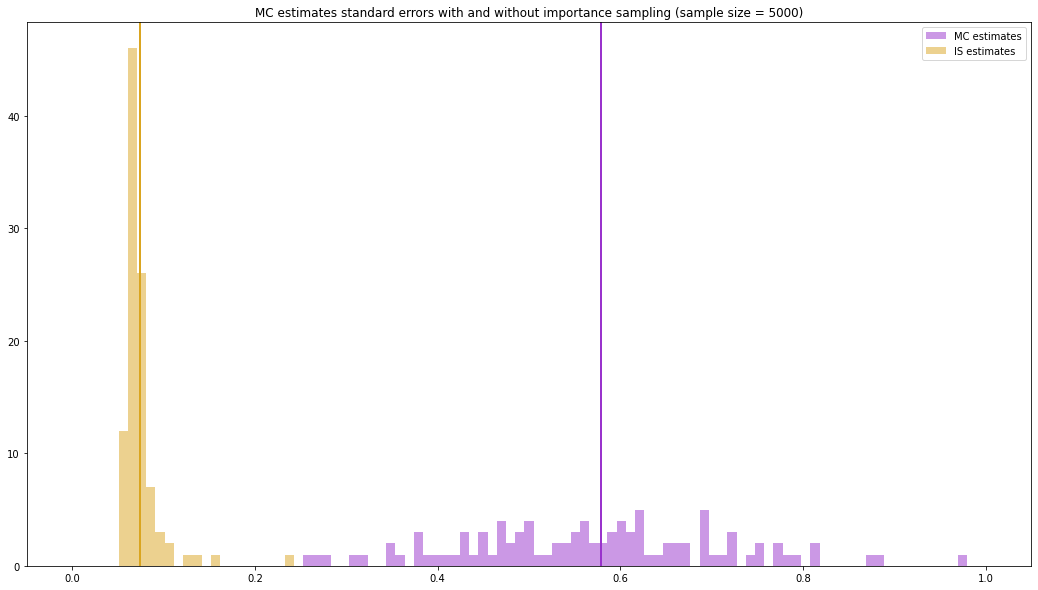

In [31]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 1.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

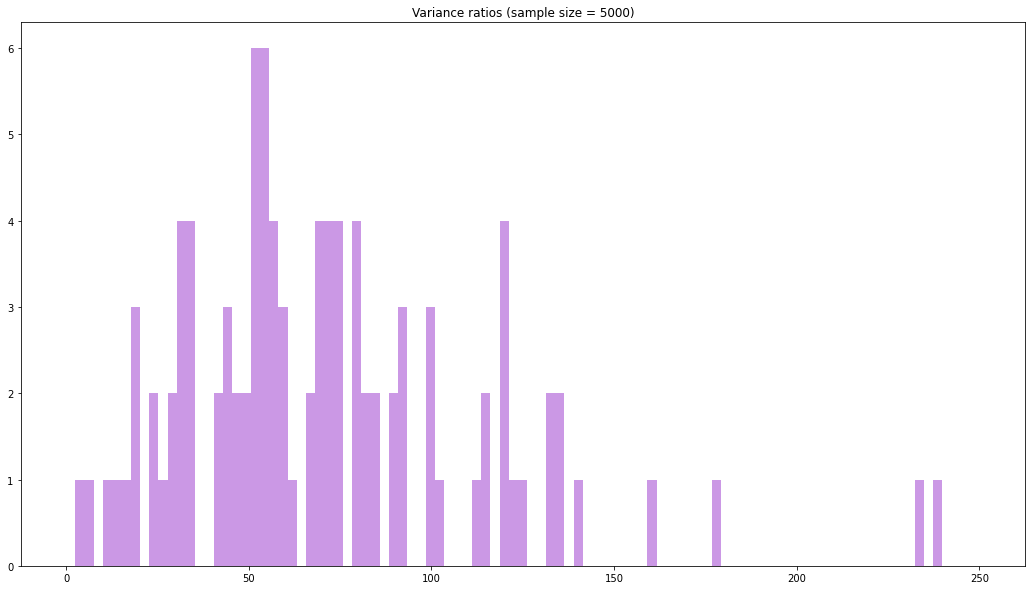

In [34]:
bins = np.linspace(0.00, 250.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.title("Variance ratios (sample size = 5000)")
plt.show()

In [33]:
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(15))

     mean MC   mean IS  stderr MC  stderr IS    varratio
31  2.802545  2.022497   0.884475   0.080741  120.000555
4   2.107901  1.909835   0.752497   0.068512  120.637172
23  2.471681  1.872802   0.719303   0.065452  120.775157
12  1.945154  1.818866   0.654804   0.059256  122.112967
61  2.172910  2.004004   0.693796   0.062049  125.025595
48  1.926059  1.749385   0.656753   0.057139  132.111903
98  2.762399  1.934834   0.726367   0.062998  132.942003
28  2.952478  1.862124   0.708649   0.061101  134.513756
82  2.282560  1.844286   0.694724   0.059692  135.454506
5   3.117676  1.880612   0.755642   0.064048  139.196145
17  2.802932  1.948776   0.786075   0.062248  159.467123
3   2.452611  1.794087   0.771370   0.057825  177.951463
1   3.980415  1.911954   0.973500   0.063687  233.650794
45  3.221074  1.842209   0.868990   0.056377  237.586723
56  2.839578  1.898127   1.270018   0.062671  410.661952
